# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from k_means_constrained import KMeansConstrained


import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras import Input, Model, layers, regularizers
from tensorflow.keras.layers import Input, Dense

2024-08-21 14:47:27.858218: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 14:47:27.974024: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 14:47:28.153695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 14:47:28.282937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 14:47:28.284160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 14:47:28.488489: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [3]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [4]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load populations

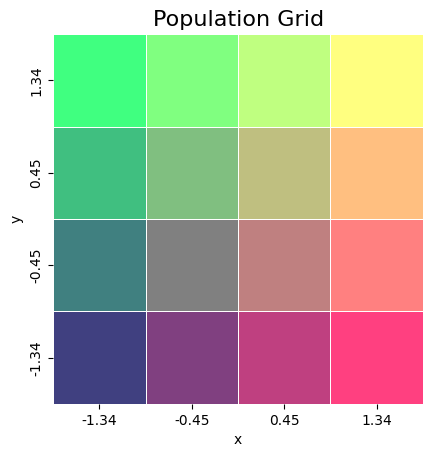

In [5]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Run abyss on everything

In [6]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(100, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        tf.keras.layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

# Function to ensure minimum cluster size
def ensure_min_cluster_size(data, labels, min_size):
    unique_labels, counts = np.unique(labels, return_counts=True)
    small_clusters = unique_labels[counts < min_size]
    
    # Reassign points from small clusters to the nearest large cluster
    for cluster in small_clusters:
        indices = np.where(labels == cluster)[0]
        for index in indices:
            # Find nearest large cluster
            nearest_large_cluster = None
            nearest_distance = float('inf')
            for label in unique_labels:
                if label not in small_clusters:
                    distance = np.linalg.norm(data.iloc[index] - kmeans.cluster_centers_[label])
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_large_cluster = label
            labels[index] = nearest_large_cluster
    
    return labels

In [7]:
complete

snps,CV101_AF_0.229375,CV109_AF_0.22375,CV110_AF_0.23,CV111_AF_0.20625,CV112_AF_0.23,CV117_AF_0.211875,CV118_AF_0.22625,CV128_AF_0.22375,CV129_AF_0.211875,CV133_AF_0.213125,...,VRV3958_AF_0.035,VRV3959_AF_0.028125,VRV3960_AF_0.05,VRV3975_AF_0.02625,VRV3977_AF_0.020625,VRV3978_AF_0.0225,VRV3986_AF_0.016875,VRV3989_AF_0.048125,VRV3999_AF_0.029375,VRV4000_AF_0.05
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,1.0,1.0,-1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
796,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
797,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
798,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
bottleneck_nr = 2 # for viz
epoch = 300
patience = 10
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)

In [9]:
bottle_2dim = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)

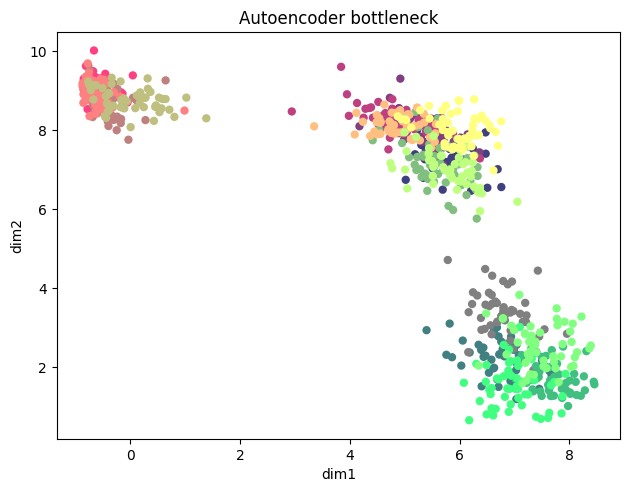

In [10]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
sns.scatterplot(x='dim1', y='dim2', data=bottle_2dim, color=colors, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Autoencoder bottleneck")

# Show the plots
plt.show()

In [11]:
bottleneck_nr = 64 # for clustering
epoch = 300
patience = 10
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)

In [12]:
bottle = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)

In [13]:
sample_size = c
num_clus = int(np.round(len(bottle)/sample_size))
size_min = sample_size - round(sample_size / 5)
size_max = sample_size + round(sample_size / 5)

# Apply constrained K-Means clustering
clf = KMeansConstrained(
    n_clusters=num_clus,
    size_min=size_min,
    size_max=size_max,
    random_state=0
)
clf.fit_predict(np.array(bottle))
bottle['cluster'] = clf.labels_

In [14]:
bottle_2dim['cluster'] = bottle['cluster']

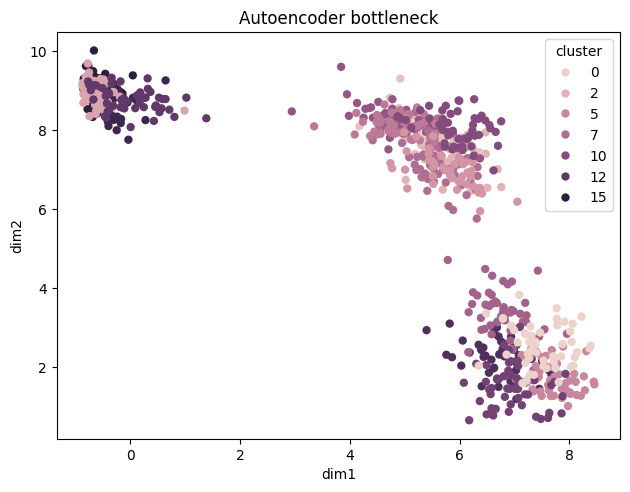

In [15]:
sns.scatterplot(x='dim1', y='dim2', data=bottle_2dim, hue='cluster', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Autoencoder bottleneck")

# Show the plots
plt.show()

In [16]:
path_bottle = f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/abyss_bottleneck"
os.makedirs(path_bottle, exist_ok=True)

In [17]:
bottle.to_pickle(f"{path_bottle}/abyss_bottleneck_{bottleneck_nr}_dims_0_zoom.pkl")